In [1]:
#math
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [2]:
mu = 3
sigma = 2
values_distr =stats.logistic(loc=mu, scale=sigma)

def gen_data(values = values_distr, num_true = 4):
    nobs = 1000
    
    #parameters
    
    
    min_bids =num_true
    max_bids =num_true
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids, nobs



bids,nobs = gen_data(values_distr)

In [3]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.logistic, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)
    

np.random.seed()
yn,nobs = gen_data(stats.logistic(loc=mu, scale=sigma))
model = Auction(yn, np.ones(len(yn))*4 )
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -2118.8
Model:                        Auction   AIC:                             4240.
Method:            Maximum Likelihood   BIC:                             4245.
Date:                Wed, 30 Dec 2020                                         
Time:                        19:05:54                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9862      0.065     46.010      0.000       2.859       3.113
par0           1.9887      0.049     40.951      0.000       1.894       2.084
==============================================================================
"""

In [4]:
def setup_shi(yn,num_bidders1 = 10, num_bidders2 = 2):
    model1 = Auction(yn,np.ones(len(yn))*num_bidders1)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,np.ones(len(yn))*num_bidders2)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,2, grad2,hess2,2

yn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn, num_bidders1 = 10, num_bidders2 = 2)

[[-0.22730162  0.18774123]
 [-0.400565   -0.11989452]]
[-0.7940907   0.72653381  0.14279319 -0.05258092]


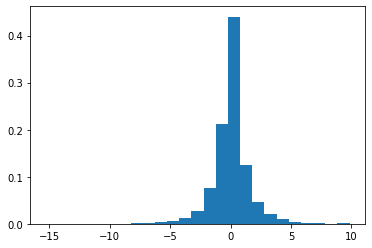

In [5]:
def compute_eigen(yn,num_bidders1 = 10, num_bidders2 = 2):
    ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,num_bidders1 = 10, num_bidders2 = 2)
    hess1 = hess1/len(ll1)
    hess2 = hess2/len(ll2)
    
    k = k1 + k2
    n = len(ll1)
    
    #A_hat:
    A_hat1 = np.concatenate([hess1,np.zeros((k1,k2))])
    A_hat2 = np.concatenate([np.zeros((k2,k1)),-1*hess2])
    A_hat = np.concatenate([A_hat1,A_hat2],axis=1)

    #B_hat, covariance of the score...
    B_hat =  np.concatenate([grad1,-grad2],axis=1) #might be a mistake here..
    B_hat = np.cov(B_hat.transpose())
    print(B_hat[0:2,2:])
    
    #compute eigenvalues for weighted chisq
    sqrt_B_hat= linalg.sqrtm(B_hat)
    W_hat = np.matmul(sqrt_B_hat,linalg.inv(A_hat))
    W_hat = np.matmul(W_hat,sqrt_B_hat)
    V,W = np.linalg.eig(W_hat)
    print(V)
    return V

n_sims = 5000
yn,nobs = gen_data(num_true = 4)
model_eigs = compute_eigen(yn,num_bidders1 = 10, num_bidders2 = 2)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()

[[-0.30376518  0.19313067]
 [-0.569364   -0.26214484]]
[-0.65548302  0.80594166  0.14011385 -0.06963535]


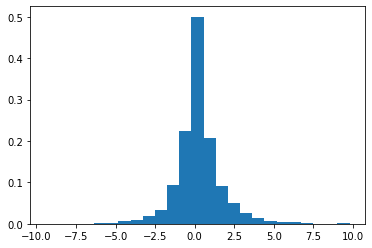

In [6]:
yn,nobs = gen_data(num_true = 10)
model_eigs = compute_eigen(yn,num_bidders1 = 10, num_bidders2 = 2)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()

[[-0.17867472  0.23327589]
 [-0.26867834 -0.06306056]]
[-1.54877929  0.69060847 -0.08540453  0.20661853]


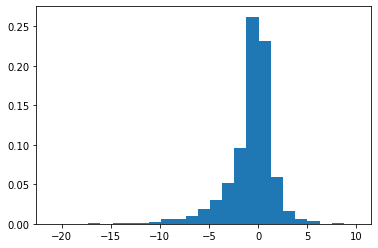

In [7]:
yn,nobs = gen_data(num_true = 2)
model_eigs = compute_eigen(yn,num_bidders1 = 10, num_bidders2 = 2)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()

[[-0.34263509  0.18169634]
 [-0.6637793  -0.3723606 ]]
[ 0.85320679 -0.68029344  0.12645231 -0.0813411 ]


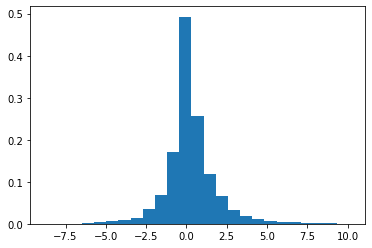

In [8]:
yn,nobs = gen_data(num_true = 13)
model_eigs = compute_eigen(yn,num_bidders1 = 10, num_bidders2 = 2)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()